In [21]:
import numpy as np
import xml.etree.ElementTree as ET
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

In [9]:
def parse_xml(file_path):
    """Parses an XML annotation file and returns a list of annotations."""

    try:
        tree = ET.parse(file_path)
        root = tree.getroot()
        filename = root.find('filename').text

        annotations = []
        for obj in root.findall('object'):
            label = obj.find('name').text
            bbox = obj.find('bndbox')
            coordinates = {
                'xmin': int(bbox.find('xmin').text),
                'ymin': int(bbox.find('ymin').text),
                'xmax': int(bbox.find('xmax').text),
                'ymax': int(bbox.find('ymax').text)
            }
            annotations.append({'filename': filename, 'label': label, 'bbox': coordinates})

        return annotations

    except FileNotFoundError:
        print(f"Error: File not found: {file_path}")  
        return []  
    except ET.ParseError:
        print(f"Error: XML parse error: {file_path}")  
        return []  
    except AttributeError as e:
        print(f"Error: Missing element in XML: {file_path}. Details: {e}") 
        return []

In [10]:
ANNOTATION_PATH = '/kaggle/input/face-mask-detection/annotations'

def process_annotations(annotation_path):
    """Parses XML annotations and returns a Pandas DataFrame."""

    data = []
    for filename in os.listdir(annotation_path):
        if filename.endswith('.xml'):  # Check for .xml extension explicitly
            file_path = os.path.join(annotation_path, filename)
            annotations = parse_xml(file_path) 

            for annotation in annotations:
                data.append([annotation['filename'], annotation['label'], annotation['bbox']])

    return pd.DataFrame(data, columns=['filename', 'label', 'bbox'])


df = process_annotations(ANNOTATION_PATH)
print(df['label'].value_counts())

label
with_mask                3232
without_mask              717
mask_weared_incorrect     123
Name: count, dtype: int64


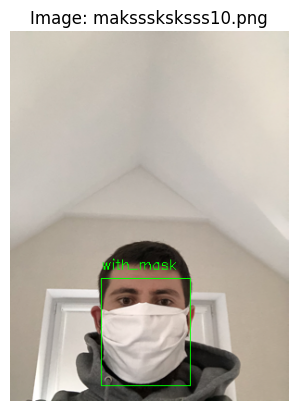

In [15]:
def visualize_annotations(image_path, annotations):
    """Visualizes annotations on an image.

    Args:
        image_path: Path to the image file.
        annotations: A list of annotation dictionaries, where each dictionary
                     contains 'filename', 'label' and 'bbox' keys.  'bbox' should be a
                     dictionary with 'xmin', 'ymin', 'xmax', and 'ymax' keys.
    """
    try:
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {image_path}")

        # Check if annotations is empty before looping
        if not annotations:
          print("No annotations found for this image.")
          plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
          plt.title(f"Image: {image_path.split('/')[-1]}") # Set title to image name
          plt.axis('off') 
          plt.show()
          return 

        for ann in annotations:
            bbox = ann['bbox']
            label = ann['label']
            filename = ann['filename']

            # Check for valid bounding box coordinates
            if all(coordinates >= 0 for coordinates in bbox.values()) and bbox['xmin'] < bbox['xmax'] and bbox['ymin'] < bbox['ymax']:
                cv2.rectangle(image, (bbox['xmin'], bbox['ymin']), (bbox['xmax'], bbox['ymax']), (0, 255, 0), 1)
                cv2.putText(image, label, (bbox['xmin'], bbox['ymin'] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
            else:
                print(f"Warning: Invalid bounding box coordinates for label '{label}' in image {image_path}")

        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Image: {filename}") 
        plt.axis('off') 
        plt.show()

    except FileNotFoundError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")


image_path = '/kaggle/input/face-mask-detection/images/maksssksksss10.png'
annotations = parse_xml('/kaggle/input/face-mask-detection/annotations/maksssksksss10.xml')
visualize_annotations(image_path, annotations)

In [17]:
IMAGE_PATH = '/kaggle/input/face-mask-detection/images/'
LABEL_MAP = {
    'with_mask': 0,
    'without_mask': 1,
    'mask_weared_incorrect': 2
}

def create_face_dataset(df, image_path, target_size=(224, 224)):
    """Creates a PyTorch dataset of face images and labels.

    Args:
        df: Pandas DataFrame containing 'filename', 'label', and 'bbox' columns.
        image_path: Path to the directory containing the images.
        target_size: Tuple (height, width) specifying the desired size of the images.

    Returns:
        Tuple (face_images, face_labels), where face_images is a PyTorch tensor
        and face_labels is a PyTorch tensor. Returns empty tensors if an error occurs.
    """

    face_images = []
    face_labels = []

    try:
        for _, row in df.iterrows():
            bbox = row['bbox']
            image_path_full = os.path.join(image_path, row['filename'])
            image = cv2.imread(image_path_full)

            if image is None:
                print(f"Error: Could not read image {image_path_full}")
                return torch.tensor([]), torch.tensor([])

            cropped_image = image[bbox['ymin']:bbox['ymax'], bbox['xmin']:bbox['xmax']]
            resized_image = cv2.resize(cropped_image, target_size)
            
            # Convert to PyTorch tensor and adjust dimensions (HWC to CHW)
            image_tensor = transforms.ToTensor()(resized_image)

            # Normalize (using ImageNet stats, common practice)
            image_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image_tensor)
            
            face_images.append(image_tensor)
            face_labels.append(LABEL_MAP[row['label']])

        # Stack the list of tensors into a single tensor
        face_images = torch.stack(face_images)
        face_labels = torch.tensor(face_labels)  # Create a tensor from the list

        return face_images, face_labels

    except Exception as e:
        print(f"An error occurred: {e}")
        return torch.tensor([]), torch.tensor([])


face_images, face_labels = create_face_dataset(df, IMAGE_PATH)

if face_images.nelement() > 0: 
    print(face_images.shape)
    print(face_labels.shape)
else:
    print("Failed to create the face dataset.")

torch.Size([4072, 3, 224, 224])
torch.Size([4072])


In [20]:
def get_augmentation_transform(p=0.5): 
    """Creates a PyTorch transformation pipeline for data augmentation.

    Args:
        p (float): The probability of applying the RandomApply transformation.

    Returns:
        torchvision.transforms.Compose: A composition of transformations.
    """

    transform_list = []

    transform_list.extend([
        transforms.RandomApply([
            transforms.RandomRotation(degrees=25),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=(0.1,0.1)), # Combined zoom, shear, translate
            transforms.RandomHorizontalFlip(p=0.5) # Horizontal flip
        ], p=p),
        transforms.ToTensor() 
    ])

    return transforms.Compose(transform_list)



# Example usage:
augmentation = get_augmentation_transform()

# Example of applying the augmentation to a PIL Image:
# image = Image.open("image.jpg")  # Assuming you have a PIL Image
# augmented_image = augmentation(image)

# Example of applying the augmentation to a tensor:
# image_tensor = torch.randn(3, 224, 224) # Example tensor
# augmented_tensor = augmentation(image_tensor)

In [22]:
def split_data(features, labels, test_size=0.2, random_state=42, stratify=None):
    """Splits data into training and testing sets.

    Args:
        features: The feature data (e.g., face images). NumPy array or PyTorch tensor.
        labels: The labels corresponding to the features. NumPy array or PyTorch tensor.
        test_size: The proportion of the data to include in the test set.
        random_state: Controls the random number generation for shuffling.
        stratify: Data to stratify on.  If labels are imbalanced, this is very important.

    Returns:
        Tuple: train_features, test_features, train_labels, test_labels.  Returns empty arrays/tensors if there's an issue.
    """

    try:
        train_features, test_features, train_labels, test_labels = train_test_split(
            features, labels, test_size=test_size, random_state=random_state, stratify=stratify
        )
        return train_features, test_features, train_labels, test_labels

    except Exception as e:
        print(f"Error during data split: {e}")
        # Return empty arrays or tensors depending on the input type
        if isinstance(features, np.ndarray):
            return np.array([]), np.array([]), np.array([]), np.array([])
        elif isinstance(features, torch.Tensor):
            return torch.tensor([]), torch.tensor([]), torch.tensor([]), torch.tensor([])
        else:
            return None, None, None, None 



train_x, test_x, train_y, test_y = split_data(face_images, face_labels, test_size=0.2, random_state=42, stratify=face_labels)

if train_x is not None:
    print("Train data shape:", train_x.shape)
    print("Test data shape:", test_x.shape)
else:
    print("Data split failed.")

Train data shape: torch.Size([3257, 3, 224, 224])
Test data shape: torch.Size([815, 3, 224, 224])
